# Линейные модели в машинном обучении

**Цель и задачи:** разработать модель МО для владелеца молочного хозяйства «Вольный луг». Первая модель будет прогназировать возможный удой коровы, вторая - рассчитывать вероятность получить вкусное молоко от коровы.

**План работы**
1. [Загрузка данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Корреляционный анализ](#4)
5. [Обучение модели линейной регрессии](#5)
6. [Обучение модели логистической регрессии](#6)
7. [Итоговые выводы](#7)

**Описание данных**

В основных данных есть информация о стаде фермера на текущий момент, имя папы каждой коровы в стаде фермера, данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

Датасет - стадо фермера на текущий момент `ferma_main.csv`.
- `id` — уникальный идентификатор коровы.
- `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
- `ЭКЕ` (Энергетическая кормовая единица) — показатель питательности корма коровы.
- `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
- `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Жирность,%` — содержание жиров в молоке (в процентах).
- `Белок,%` — содержание белков в молоке (в процентах).
- `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- `Возраст` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Датасет - имя папы каждой коровы в стаде фермера `ferma_dad.csv`.
- `id` — уникальный идентификатор коровы.
- `Имя Папы` — имя папы коровы.

Датасет `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.
- `Порода` — порода коровы.
- `Тип пастбища` — ландшафт лугов, на которых паслась корова.
- `порода папы_быка` — порода папы коровы.
- `Имя_папы` — имя папы коровы.
- `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
- `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
- `Возраст` — возраст коровы, бинарный признак (менее 2 лет, более 2 лет).

**Библиотеки для проекта**

In [1]:
import pandas as pd
from scipy import stats as st
from scipy.stats import kstest
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, 
                             accuracy_score, precision_score, recall_score, confusion_matrix) 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


**Стили и форматы**

In [4]:
#отображаем максимальное число столбцов
pd.set_option('display.max_columns', None)

# формат дробных чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

## Загрузка данных <a id='1'></a>

### Загрузить данные в датафреймы pandas

Загружаем 3 датафрейма, присвоим им соотвествующие переменны `ferma_main`, `ferma_dad`, `cow_buy`.

In [5]:
ferma_main = pd.read_csv('datasets/ferma_main.csv', sep=';')
ferma_dad = pd.read_csv('datasets/ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('datasets/cow_buy.csv', sep=';')

### Изучить данные

Напишем функию, которая выведет все данные о 3 датасетах.

In [6]:
def df_info(data):
    display(data.head(7))
    display(data.info())

Рассмотрим датафрейм `ferma_main`.

In [7]:
df_info(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет
5,6,5254,"12,7",1806,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,13","3,078",вкусно,менее_2_лет
6,7,5910,"13,2",1792,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,48","3,077",вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

None

Итак, в датасете `ferma_main` есть:
- название стоблца `порода папы_быка`. Он стилистически отличается от других стоблцов, преобразуем его как `Порода папы быка`;
- столбцы `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%` имеют тип `object`. В предобработке данных изменим им тип на `float64`.
- в датасете отсутствуют пропуски, всего значений  634.

In [8]:
ferma_main = ferma_main.rename(columns={'порода папы_быка':'Порода папы быка'})

Рассмотрим датафрейм `ferma_dad`. 

In [9]:
df_info(ferma_dad)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

В датасете `ferma_dad` 
- отсутствуют 0 значения. В датафрейме 629 строк;
- заменим название столбца `Имя Папы` на `Имя папы`.

In [10]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы':'Имя папы'})

Рассмотрим датафрейм `cow_buy`.

In [11]:
df_info(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

В датафрейме `cow_buy`:
- отсутствуют 0 значения. В датафрейме всего 20 строк.
- названия столбцов `порода папы_быка`, `Имя_папы`, `Текущая_жирность,%`, `Текущий_уровень_белок,%` отличаются от общей стилистики. Заменим их на `Порода папы быка`, `Имя папы`, `Текущая жирность,%`, `Текущий уровень белок,%`.
- столбцы `Текущая_жирность,%`, `Текущий_уровень_белок,%` имеют тип `object`. В предобработке данных изменим им тип на `float64`.

In [12]:
cow_buy = cow_buy.rename(columns={'порода папы_быка':'Порода папы быка', 
                                  'Имя_папы':'Имя папы',
                                  'Текущая_жирность,%':'Текущая жирность,%',
                                  'Текущий_уровень_белок,%':'Текущий уровень белок,%',
                                 })

### Выводы

Были первично изучены следующие датасеты:

**`ferma_main`**:
- название стоблца `порода папы_быка`. Он стилистически отличается от других стоблцов, преобразовали его как `Порода папы быка`;
- столбцы `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%` имеют тип `object`. В предобработке данных изменим им тип на `float64`.
- в датасете отсутствуют пропуски, всего значений  634.

**`ferma_dad`** 
- отсутствуют 0 значения. В датафрейме 629 строк;
- изменили название столбца `Имя Папы` на `Имя папы`.

**`cow_buy`**
- отсутствуют 0 значения. В датафрейме всего 20 строк.
- названия столбцов `порода папы_быка`, `Имя_папы`, `Текущая_жирность,%`, `Текущий_уровень_белок,%` отличаются от общей стилистики. Заменили их на `Порода папы быка`, `Имя папы`, `Текущая жирность,%`, `Текущий уровень белок,%`.
- столбцы `Текущая_жирность,%`, `Текущий_уровень_белок,%` имеют тип `object`. В предобработке данных изменим им тип на `float64`.

##  Предобработка данных <a id='2'></a>

Рассмотрим столбцы типа `object`, которые содержат значения с запятой.

In [13]:
display(ferma_main['ЭКЕ (Энергетическая кормовая единица)'].sort_values().unique())
display(ferma_main['СПО (Сахаро-протеиновое соотношение)'].sort_values().unique())
display(ferma_main['Жирность,%'].sort_values().unique())
display(ferma_main['Белок,%'].sort_values().unique())

display(cow_buy['Текущая жирность,%'].sort_values().unique())
display(cow_buy['Текущий уровень белок,%'].sort_values().unique())

array(['10,9', '11,1', '11,5', '11,7', '11,8', '11,9', '12', '12,1',
       '12,2', '12,3', '12,4', '12,5', '12,6', '12,7', '12,8', '12,9',
       '13', '13,1', '13,2', '13,3', '13,4', '13,5', '13,6', '13,7',
       '13,8', '13,9', '14', '14,1', '14,2', '14,3', '14,4', '14,5',
       '14,6', '14,7', '14,8', '14,9', '15', '15,1', '15,2', '15,3',
       '15,4', '15,5', '15,6', '15,7', '15,8', '15,9', '16', '16,1',
       '16,2', '16,3', '16,4', '16,5', '16,6', '16,7', '16,8'],
      dtype=object)

array(['0,84', '0,85', '0,86', '0,88', '0,885', '0,89', '0,895', '0,9',
       '0,93', '0,94', '0,95', '0,96'], dtype=object)

array(['2,99', '3,01', '3,03', '3,11', '3,12', '3,13', '3,15', '3,16',
       '3,18', '3,19', '3,21', '3,22', '3,23', '3,24', '3,25', '3,26',
       '3,27', '3,28', '3,31', '3,32', '3,33', '3,34', '3,35', '3,37',
       '3,38', '3,39', '3,4', '3,41', '3,42', '3,44', '3,48', '3,49',
       '3,53', '3,54', '3,55', '3,57', '3,58', '3,59', '3,61', '3,62',
       '3,63', '3,64', '3,65', '3,69', '3,7', '3,71', '3,72', '3,73',
       '3,74', '3,75'], dtype=object)

array(['3,069', '3,07', '3,071', '3,072', '3,073', '3,074', '3,075',
       '3,076', '3,077', '3,078', '3,079', '3,08', '3,081', '3,082',
       '3,085'], dtype=object)

array(['3,34', '3,4', '3,42', '3,54', '3,57', '3,58', '3,59', '3,63',
       '3,64', '3,68', '3,73', '3,77'], dtype=object)

array(['3,046', '3,053', '3,055', '3,061', '3,065', '3,069', '3,073',
       '3,074', '3,075', '3,076', '3,079', '3,081'], dtype=object)

В предыдущем пункте в датасетах `ferma_main` и `cow_buy` присутсвуют столбцы, в которых нужно изменить тип данных на `float64` и заменить запятую на точку.

In [14]:
ferma_main['ЭКЕ (Энергетическая кормовая единица)'] = (ferma_main['ЭКЕ (Энергетическая кормовая единица)'].astype('str')
                                                       .str.replace(',', '.')
                                                       .astype('float'))
ferma_main['СПО (Сахаро-протеиновое соотношение)'] = (ferma_main['СПО (Сахаро-протеиновое соотношение)'].astype('str')
                                                      .str.replace(',', '.')
                                                      .astype('float'))
ferma_main['Жирность,%'] = (ferma_main['Жирность,%'].astype('str')
                            .str.replace(',', '.')
                            .astype('float'))
ferma_main['Белок,%'] = (ferma_main['Белок,%'].astype('str')
                         .str.replace(',', '.')
                         .astype('float'))

display(ferma_main.info())

cow_buy['Текущая жирность,%'] = (cow_buy['Текущая жирность,%'].astype('str')
                                 .str.replace(',', '.')
                                 .astype('float'))

cow_buy['Текущий уровень белок,%'] = (cow_buy['Текущий уровень белок,%'].astype('str')
                                      .str.replace(',', '.')
                                      .astype('float'))

display(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   Порода папы быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   Порода папы быка         20 non-null     object 
 3   Имя папы                 20 non-null     object 
 4   Текущая жирность,%       20 non-null     float64
 5   Текущий уровень белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

Тепрь с типами данных все в порядке :)

Еще раз проверим датасеты на наличие пустых строк.

In [15]:
raw = ['ferma_main', 'ferma_dad', 'cow_buy']

for r in raw:
    display('Количество пустых строк', r , locals()[r].isna().sum())

'Количество пустых строк'

'ferma_main'

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
Порода папы быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

'Количество пустых строк'

'ferma_dad'

id          0
Имя папы    0
dtype: int64

'Количество пустых строк'

'cow_buy'

Порода                     0
Тип пастбища               0
Порода папы быка           0
Имя папы                   0
Текущая жирность,%         0
Текущий уровень белок,%    0
Возраст                    0
dtype: int64

Видим, что пустые строки отсутствуют. Проверим на наличие явных дубликатов.

In [16]:
for r in raw:
    display('Дубликаты в', r, locals()[r].duplicated().sum())

'Дубликаты в'

'ferma_main'

5

'Дубликаты в'

'ferma_dad'

0

'Дубликаты в'

'cow_buy'

4

В 2 датасетах (`ferma_main`=5 и `cow_buy`=4) присутствуют дубликаты. Выведем эти дубликаты для каждого датасета.

In [17]:
ferma_main_duplicated = ferma_main[ferma_main.duplicated()]
display(ferma_main_duplicated)

cow_buy_duplicated = cow_buy[cow_buy.duplicated()]
display(cow_buy_duplicated)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
630,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
631,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
632,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет
633,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет


,Порода,Тип пастбища,Порода папы быка,Имя папы,"Текущая жирность,%","Текущий уровень белок,%",Возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет


Скорее всего, в первом датасете соединили данные из разных источников. Для 2-го датасета пропуски не нужно убирать, т.к. это тестовые данные. Уберем пропуски из `ferma_main`.

In [18]:
ferma_main.drop_duplicates(inplace=True)

#проверяем
for r in raw:
    display('Дубликаты в', r, locals()[r].duplicated().sum())

'Дубликаты в'

'ferma_main'

0

'Дубликаты в'

'ferma_dad'

0

'Дубликаты в'

'cow_buy'

4

Рассмотрим категориальные значения датафреймов `ferma_main`, `ferma_dad`, `cow_buy`.

**`ferma_main`**

In [19]:
display('Значения столбца Порода', ferma_main['Порода'].sort_values().unique())
display('Значения столбца Тип пастбища', ferma_main['Тип пастбища'].sort_values().unique())
display('Значения столбца Порода папы быка', ferma_main['Порода папы быка'].sort_values().unique())
display('Значения столбца Вкус молока', ferma_main['Вкус молока'].sort_values().unique())
display('Значения столбца Возраст', ferma_main['Возраст'].sort_values().unique())

'Значения столбца Порода'

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

'Значения столбца Тип пастбища'

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

'Значения столбца Порода папы быка'

array(['Айдиал', 'Айдиалл', 'Соверин'], dtype=object)

'Значения столбца Вкус молока'

array(['вкусно', 'не вкусно'], dtype=object)

'Значения столбца Возраст'

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Из общей стилистики выбиваются столбцы:

- `Порода` со значением `РефлешнСоверинг`. Изменим его на `Рефлешн Соверинг`.
- `Вкус молока` со значениями `вкусно` и `не вкусно`. Приведем их заглавную букву к верхнему регистру.
- `Возраст` со значениями  `более_2_лет` и `менее_2_лет`. Заменим их на `Более 2 лет` и `Менее 2 лет`.

В столбцах присутствуют неявные дубли:
- `Порода папы быка` присутствует уникальное значение `Айдиалл`. Заменим эти значения на `Айдиал`.
- `Тип пастбища` присутствует уникальное значение `Равнинные`. Заменим эти значения на `Равнинное`.

Ниже поменяем все перечисленные значения.

In [20]:
ferma_main['Порода'] = ferma_main['Порода'].replace('РефлешнСоверинг', 'Рефлешн Соверинг')
ferma_main['Вкус молока'] = ferma_main['Вкус молока'].replace(['вкусно', 'не вкусно'], ['Вкусно', 'Не вкусно'])
ferma_main['Возраст'] = ferma_main['Возраст'].replace(['более_2_лет', 'менее_2_лет'], ['Более 2 лет', 'Менее 2 лет'])

ferma_main['Порода папы быка'] = ferma_main['Порода папы быка'].replace('Айдиалл', 'Айдиал')
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].replace('Равнинные', 'Равнинное')

**`ferma_dad`**

In [21]:
display('Значения столбца Имя папы', ferma_dad['Имя папы'].sort_values().unique())

'Значения столбца Имя папы'

array(['Барин', 'Буйный', 'Геркулес', 'Соловчик'], dtype=object)

В датасете `ferma_dad` категориальные значения стилистически выглядят верно.

**`cow_buy`**

In [22]:
display('Значения столбца Порода', cow_buy['Порода'].sort_values().unique())
display('Значения столбца Тип пастбища', cow_buy['Тип пастбища'].sort_values().unique())
display('Значения столбца Порода папы быка', cow_buy['Порода папы быка'].sort_values().unique())
display('Значения столбца Имя папы', cow_buy['Имя папы'].sort_values().unique())
display('Значения столбца Возраст', cow_buy['Возраст'].sort_values().unique())

'Значения столбца Порода'

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

'Значения столбца Тип пастбища'

array(['равнинное', 'холмистое'], dtype=object)

'Значения столбца Порода папы быка'

array(['Айдиал', 'Соверин'], dtype=object)

'Значения столбца Имя папы'

array(['Барин', 'Буйный', 'Геркулес', 'Соловчик'], dtype=object)

'Значения столбца Возраст'

array(['более_2_лет', 'менее_2_лет'], dtype=object)

Из общей стилистики выбиываются столбцы:

- `Порода` со значением `РефлешнСоверинг`. Изменим его на `Рефлешн Соверинг`.
- `Тип пастбища` со значениями `равнинное` и `холмистое`. Приведем их заглавные буквы к верхним регистрам.
- `Возраст` со значениями  `более_2_лет` и `менее_2_лет`. Заменим их на `Более 2 лет` и `Менее 2 лет`.

Ниже поменям все перечисленные значения.

In [23]:
cow_buy['Порода'] = cow_buy['Порода'].replace('РефлешнСоверинг', 'Рефлешн Соверинг')
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].replace(['равнинное', 'холмистое'], ['Равнинное', 'Холмистое'])
cow_buy['Возраст'] = cow_buy['Возраст'].replace(['более_2_лет', 'менее_2_лет'], ['Более 2 лет', 'Менее 2 лет'])

### Выводы

- Были преобразованы числовые значения в тип `float` в столбцах `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%` `Белок,%'` для датасета `ferma_main`.
- Были преобразованы числовые значения в тип `float` в столбцах `Текущая жирность,%` и `Текущий уровень белок,%` для датасета `cow_buy`.
- В датасетах отсуствуют пустые строки.
- Убрали 5 дубликатов из `ferma_main`.
- В таблицах: 
    - `ferma_main` присутстовали неявные  дубликаты в категориальных столбцах `Порода папы быка` и `Тип пастбища`. Также привели к общему стилю столбцы `Порода`, `Вкус молока`, `Возраст`.
    - `cow_buy` привели к общему стилю столбцы `Порода`, `Тип пастбища` и `Возраст`.

## Исследовательский анализ данных <a id='3'></a>

### 1-2 Провести статистический анализ всех признаков и построить графики

Для начала, посмотрим столбцы с категориальными значениями: соотношение пород, тип пастбищ, пород папы быков, вкус молока и возраст в датасете `ferma_main`. Для этого напишем функцию.

In [24]:
#ind - категориальный столбец, который мы исследуем

def ferma_pivot(ind):
    
    ferma_main_pivot = (ferma_main.pivot_table(index = ind, 
                                               values = 'id',
                                               aggfunc='count')
                        .sort_values(by='id')
                        .rename(columns = {'id' : 'count'}))
    
    (ferma_main_pivot.plot.pie(y='count',
                      autopct='%.0f%%', 
                      figsize=(10, 10), 
                      legend=False, 
                      wedgeprops=dict(width=0.5))
     .set_title('Cоотношение ' + ind + ' коров'));
    plt.ylabel('');
    

In [25]:
ferma_main.head(5)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Порода папы быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,Вкусно,Более 2 лет
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.08,Вкусно,Менее 2 лет
2,3,5810,14.00,1854,0.89,Рефлешн Соверинг,Холмистое,Соверин,3.59,3.07,Не вкусно,Более 2 лет
3,4,5895,12.40,2012,0.89,Рефлешн Соверинг,Холмистое,Айдиал,3.40,3.08,Не вкусно,Более 2 лет
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.07,Вкусно,Менее 2 лет


### Соотношение всречаеммости породы

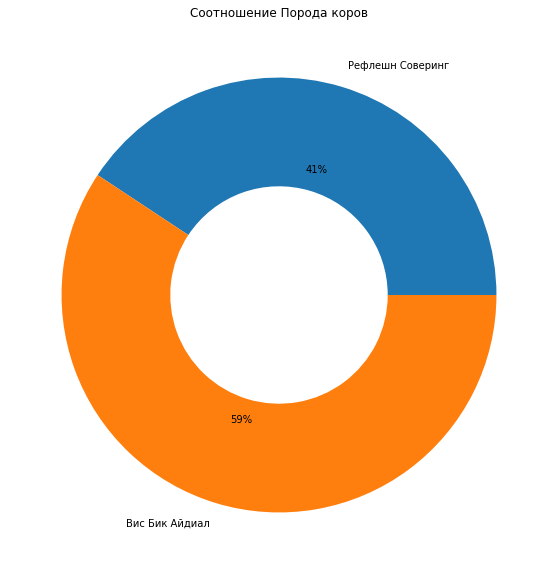

In [26]:
ferma_pivot('Порода')

Итак, порода коров Вис Бик Айдиал составляет 59% от общего числа коров. Порода Рефлешн Соверинг всего 41%.

### Соотношение типа пастбища коров

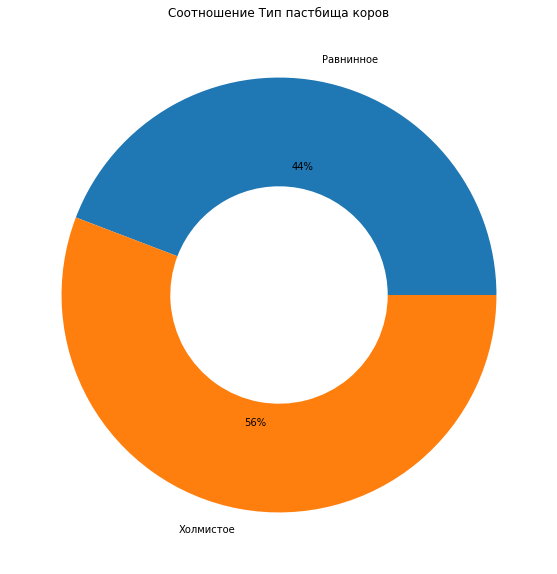

In [27]:
ferma_pivot('Тип пастбища')

На пастбище преобладют холомистые коровы (56%), на пастбище всего составлет 44%.

### Соотношение происхлждения от "папы" быка

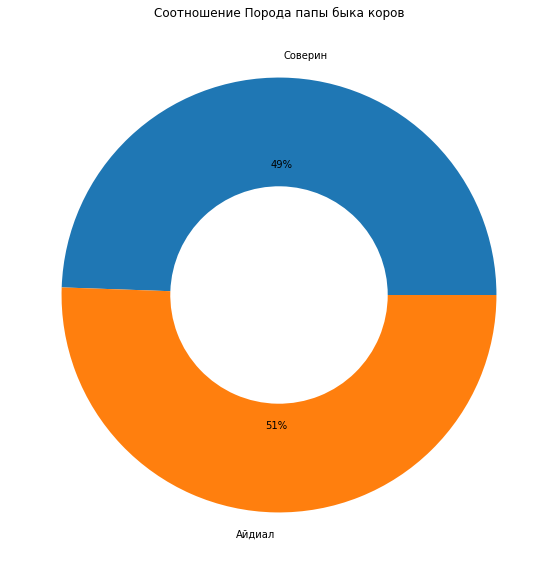

In [28]:
ferma_pivot('Порода папы быка')

Практически в равном соотношении находятся коровы от `Айдиал` (51%) и `Соверин` (49%). 

### Соотношение вкуса молока

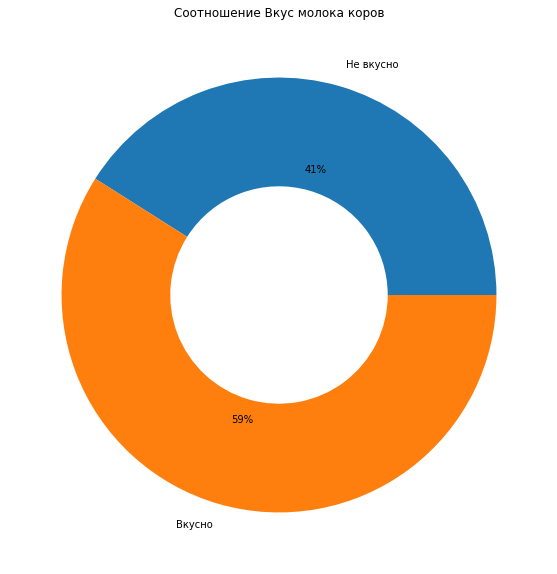

In [29]:
ferma_pivot('Вкус молока')

Фермер отметил, что всего 59% коров дают вкусное молоко. 41% дают не вкусное. В целевой переменной присутствует дисбаланс. Мажорным классом в нашем конкретном случае является вкусное молоко. Из-за этого модель будет лучше улавливать закономерности обширного класса. Как я понимаю, тут нужно провести оверсэмплинг.

### Соотношения возраста коров

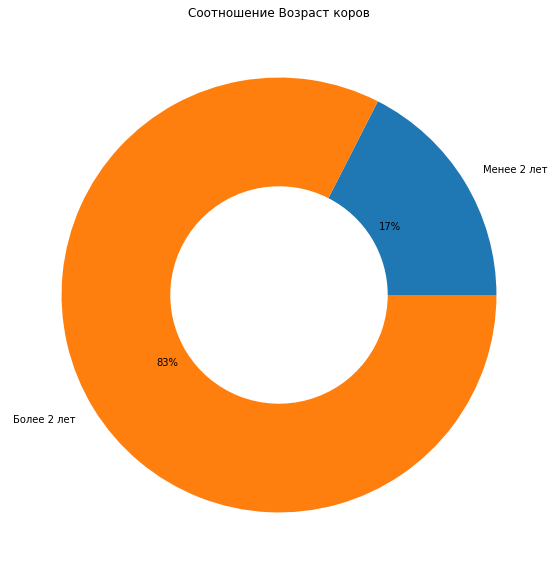

In [30]:
ferma_pivot('Возраст')

В основном преобладают коровы, которым больше 2 лет - 83%, против 17% (менее 2 лет).

Теперь рассмотрим количественные значения в столбцах: `Удой, кг`, `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%` и `Белок,%`. Напишем функцию для вывода графиков и описательную статистику. 

### Удой коров

Построим гистограммы для колличественных данных. Также воспользуемся критерием Колмагорова-Смирнова, чтобы определить, распределены ли данные нормально:

- H0: ferma_main['столбец с кол. знач.'] = N(μ, σ^2)
- H1: ferma_main['столбец с кол. знач.'] ≠ N(μ, σ^2)

In [31]:
# kol -столбец с количественными значениями
def kol_ferma_main(kol):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(ferma_main[kol], ax=ax_box).set_title(f'{kol} коров');
    sns.histplot(data=ferma_main, x=kol, ax=ax_hist, bins=20);
    
    ax_box.set(xlabel='');
    plt.xlabel(f'{kol}');
    plt.ylabel('Частота');
    
    plt.axvline(x=ferma_main[kol].mean(), color='g', linestyle='-', label=f'mean: {ferma_main[kol].mean()}');
    plt.axvline(x=ferma_main[kol].median(), color='g', linestyle='--', label=f'median: {ferma_main[kol].median()}');
    plt.legend();
    
    display(ferma_main[kol].describe())

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count      629.00
mean     6,188.75
std      1,644.80
min      5,204.00
25%      5,751.00
50%      6,133.00
75%      6,501.00
max     45,616.00
Name: Удой, кг, dtype: float64

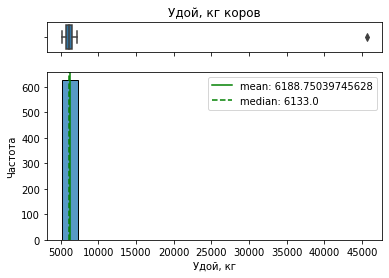

In [32]:
kol_ferma_main('Удой, кг')

Итак, на графике видно, что одна корова дала 45616 кг молока в год. Данное значение является выбросом и повторно построим график.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count     628.00
mean    6,125.97
std       475.86
min     5,204.00
25%     5,749.75
50%     6,132.50
75%     6,501.00
max     7,222.00
Name: Удой, кг, dtype: float64

KstestResult(statistic=1.0, pvalue=0.0)

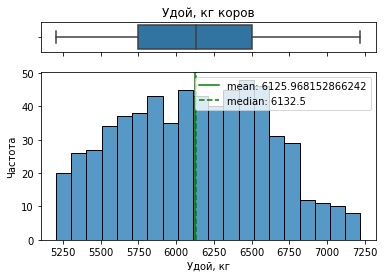

In [33]:
#ferma_main = ferma_main.query('Удой, кг != 45616')
ferma_main = ferma_main[ferma_main['Удой, кг'] != max(ferma_main['Удой, кг'])]
kol_ferma_main('Удой, кг')
kstest(ferma_main['Удой, кг'], 'norm')

Тепрь все выглядит шикарно :). Видим, что средняя находится левее медианы, это означает, что распределение имеет отрицательную асимметрию. В среднем коровы дают 6123 кг молока. Минимальный удой в год составляет 5204 кг, а максимальный 7113 кг. Распределение не явлеятся нормальным, т.к. pvalue<0.5.

### Энергетическая кормовая единица коров

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count   628.00
mean     14.55
std       1.30
min      10.90
25%      13.50
50%      14.70
75%      15.60
max      16.80
Name: ЭКЕ (Энергетическая кормовая единица), dtype: float64

KstestResult(statistic=1.0, pvalue=0.0)

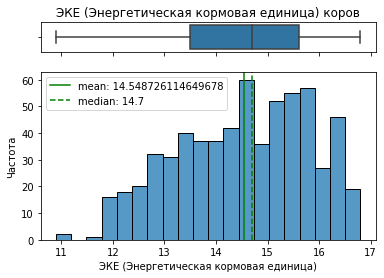

In [34]:
kol_ferma_main('ЭКЕ (Энергетическая кормовая единица)')
kstest(ferma_main['ЭКЕ (Энергетическая кормовая единица)'], 'norm')

Медиана больше среднего значения, распределение переменной имеет отрицательную асимметрию. В среднем коровы получают 17.7 ЭКЕ. Распределение не явлеятся нормальным, т.к. pvalue<0.5.

### Cодержание сырого протеина в корме

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count     628.00
mean    1,923.76
std       182.83
min     1,660.00
25%     1,771.75
50%     1,888.00
75%     2,062.25
max     2,349.00
Name: Сырой протеин, г, dtype: float64

KstestResult(statistic=1.0, pvalue=0.0)

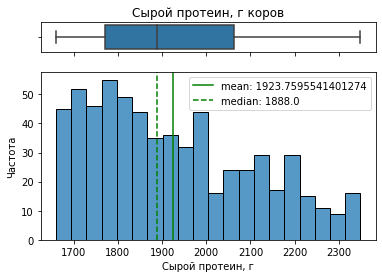

In [35]:
kol_ferma_main('Сырой протеин, г')
kstest(ferma_main['Сырой протеин, г'], 'norm', alternative='less')

Содержание протеина в корме в среднем составляет 1920 г. При этом среднее значение больше медианы, это означает что распределение имеет положительную асимметрию. Распределение не явлеятся нормальным, т.к. pvalue<0.5.

### Отношение сахара к протеину в корме коровы

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count   628.00
mean      0.91
std       0.03
min       0.84
25%       0.89
50%       0.93
75%       0.94
max       0.96
Name: СПО (Сахаро-протеиновое соотношение), dtype: float64

KstestResult(statistic=0.7995458067395503, pvalue=0.0)

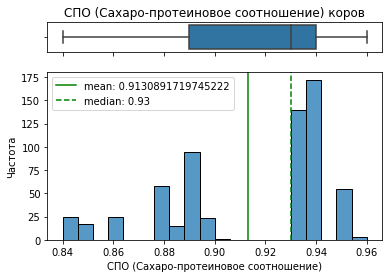

In [36]:
kol_ferma_main('СПО (Сахаро-протеиновое соотношение)')
kstest(ferma_main['СПО (Сахаро-протеиновое соотношение)'], 'norm')

Данное распределение не похоже на нормальное, да и в целом, сложно к нему подобрать из всех существующих  и  pvalue<0.5. Лучшим решением будет создать новый столбец `СПО 09` со значениями из столбца в `СПО (Сахаро-протеиновое соотношение)`: `меньше 0.9` и `больше 0.9`.

In [37]:
#функция для столбца СПО 09
def spo(rate):
    if rate <= 0.9:
        return 'меньше 0.9'
    return 'больше 0.9'

Добавим новый столбец `СПО 09`.

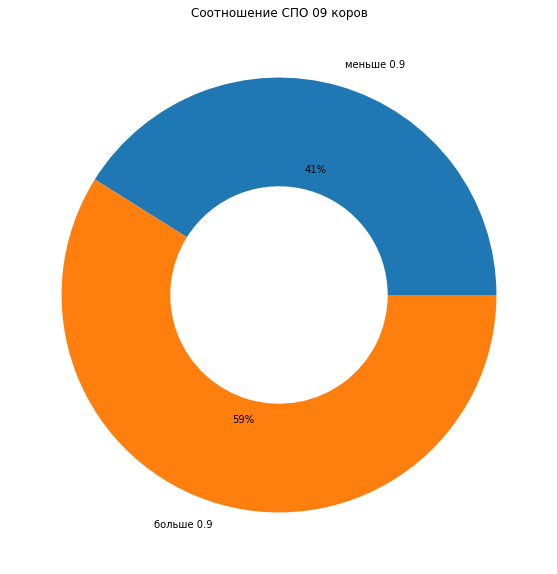

In [38]:
ferma_main['СПО 09'] = ferma_main['СПО (Сахаро-протеиновое соотношение)'].apply(spo)
ferma_pivot('СПО 09')

В общем, соотношения сахара к протеину при значение больше 0.9 составляет 59%.

### Cодержание жиров в молоке

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count   628.00
mean      3.60
std       0.17
min       2.99
25%       3.59
50%       3.65
75%       3.72
max       3.75
Name: Жирность,%, dtype: float64

KstestResult(statistic=0.9986051127645078, pvalue=0.0)

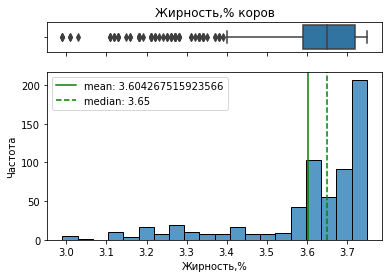

In [39]:
kol_ferma_main('Жирность,%')
kstest(ferma_main['Жирность,%'], 'norm')

Cодержание жиров в молоке не распределена нормально и pvalue<0.5. Аналогично создадим столбец `Жирность 3.6` на `меньше 3.6` и `больше 3.6`.

In [40]:
#функция для столбца Жирность 3.6
def fat(rate):
    if rate <= 3.6:
        return 'меньше 3.6'
    return 'больше 3.6'

Добавим новый столбец `Жирность 3.6`.

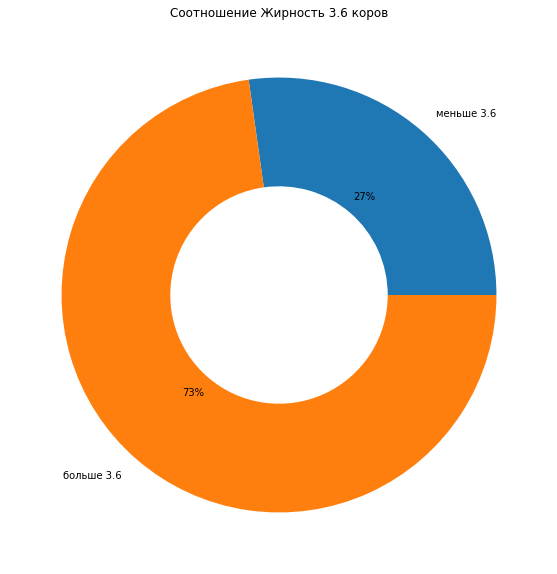

In [41]:
ferma_main['Жирность 3.6'] = ferma_main['Жирность,%'].apply(fat)
ferma_pivot('Жирность 3.6')

В общем, жирность молока при значение 3.6 и более составляет 73%.

### Cодержание белков в молоке

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count   628.00
mean      3.08
std       0.00
min       3.07
25%       3.07
50%       3.08
75%       3.08
max       3.08
Name: Белок,%, dtype: float64

KstestResult(statistic=0.9986051127645078, pvalue=0.0)

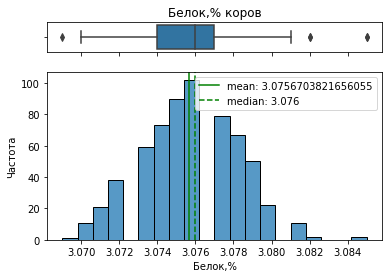

In [42]:
kol_ferma_main('Белок,%')
kstest(ferma_main['Жирность,%'], 'norm')

Содержание белков  и в средем составляет 3.08%. Распределение не явлеятся нормальным, т.к. pvalue<0.5.

### Выводы

- Порода коров Вис Бик Айдиал составляет `59%` от общего числа коров. Порода Рефлешн Соверинг всего `41%`.
- На пастбище преобладют холомистые коровы `56%`, на пастбище всего составлет `44%`.
- Практически в равном соотношении находятся коровы от Айдиал `51%` и Соверин `49%`.
- Фермер отметил, что всего `59%` коров дают вкусное молоко. `41%` дают не вкусное.
- В основном преобладают коровы, которым больше 2 лет - `83%`, против `17%` (менее 2 лет).
- В среднем коровы дают 6123 кг молока. Минимальный удой в год составляет 5204 кг, а максимальный 7113 кг.
- В среднем коровы получают 17.7 ЭКЕ.
- Содержание протеина в корме в среднем составляет 1920 г.
- Отношение сахара к протеину в корме коровы не распределено нормально. Было решено создать столбец `СПО 09` с категориальными значениями `больше 0.9` и `меньше 0.9`. Вышло, что соотношения сахара к протеину при значение больше 0.9 составляет 59%, менее 41%.
- Cодержание жиров в молоке не распределена нормально. Жирность молока при значение 3.6 и более составляет 73%, менее 21%.
- Содержание белков в молоке в средем составляет 3.08%.
- Ни одно из количественных значений не имеет норамльного распределения.

## Корреляционный анализ <a id='4'></a>

Ранее определили, что количественные значения не являются нормальными. Следовательно, при оценки корелляции будем использвать коэффицент Спирмена.

In [43]:
ferma_main.corr(method='spearman')

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
id,1.00,-0.00,-0.02,-0.04,-0.02,0.04,0.00
"Удой, кг",-0.00,1.00,0.77,0.44,0.79,0.69,-0.01
ЭКЕ (Энергетическая кормовая единица),-0.02,0.77,1.00,0.38,0.74,0.69,-0.01
"Сырой протеин, г",-0.04,0.44,0.38,1.00,0.49,0.39,0.23
СПО (Сахаро-протеиновое соотношение),-0.02,0.79,0.74,0.49,1.00,0.70,0.11
"Жирность,%",0.04,0.69,0.69,0.39,0.70,1.00,0.04
"Белок,%",0.00,-0.01,-0.01,0.23,0.11,0.04,1.00


Анализировать корреляцию id с другими признаками может быть не совсем корректно, поскольку id обычно является уникальным идентификатором для каждого объекта в наборе данных. Поэтому корреляция ID с другими признаками может быть случайной или не иметь реального смысла. В целом, лучше анализировать корреляцию между признаками, которые имеют непосредственное влияние друг на друга или на целевую переменную, чтобы получить более информативные результаты.

Видим, что наибольшая корелляция наблюдается между `Удой, кг` и `СПО (Сахаро-протеиновое соотношение)` (0.79), `Удой, кг` и `ЭКЕ (Энергетическая кормовая единица)` (0.77) и `СПО (Сахаро-протеиновое соотношение)` и `Жирность,%` (0.7). Следовательно, сильной линейной зависимости между значениями - нет, т.е. мультиколлинеарность отсутствует. 

In [44]:
def corr_farm_main(col_cat):
    
    ferma_main_name_num = ferma_main.select_dtypes(include=['int64', 'float64']).columns.tolist()

    sns.set_theme(rc={'figure.figsize':(6,4)})
    for col in ferma_main_name_num:
        sns.scatterplot(data=ferma_main, x=col, y="Удой, кг",  hue=col_cat).set(title=f'График рассеивания corr={st.spearmanr(ferma_main[col], ferma_main["Удой, кг"])[0]:.2f}');
        plt.legend(bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 )
        plt.show()

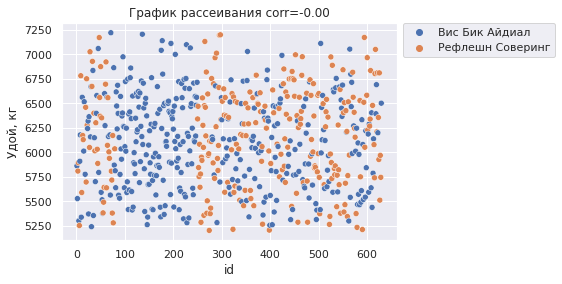

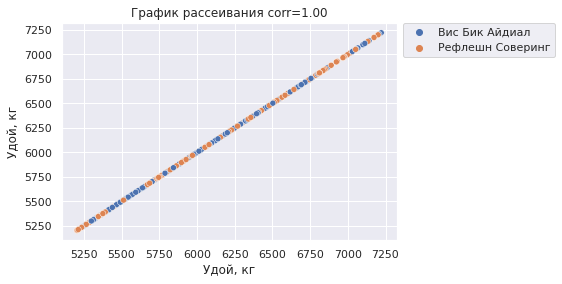

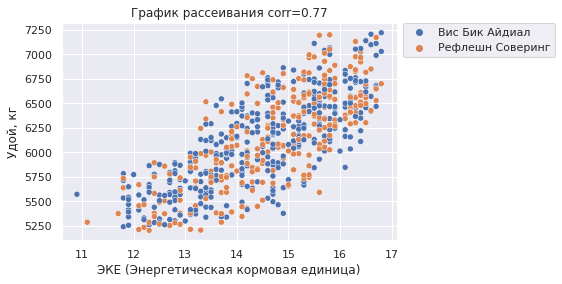

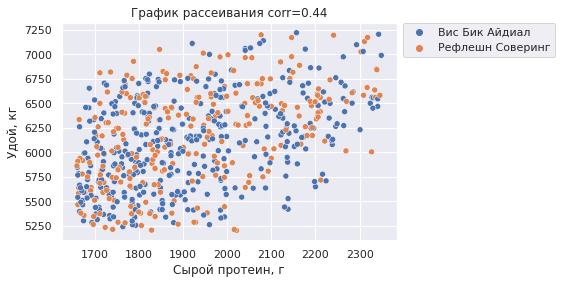

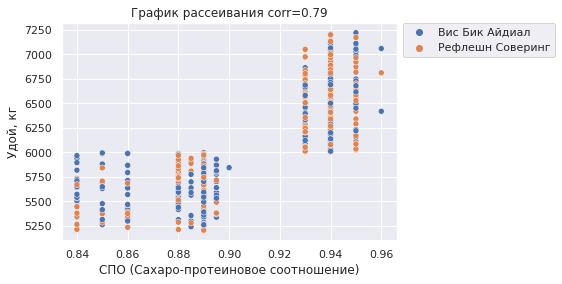

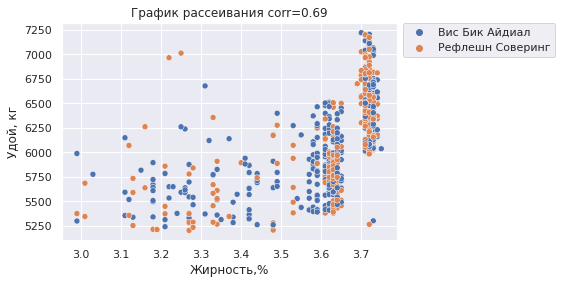

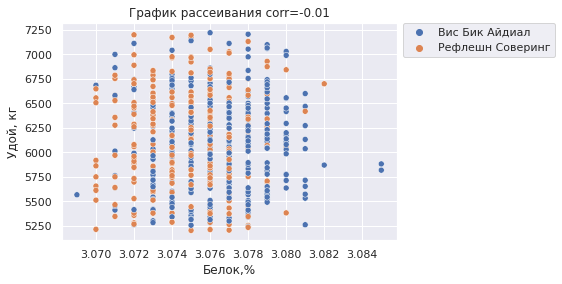

In [45]:
corr_farm_main('Порода')

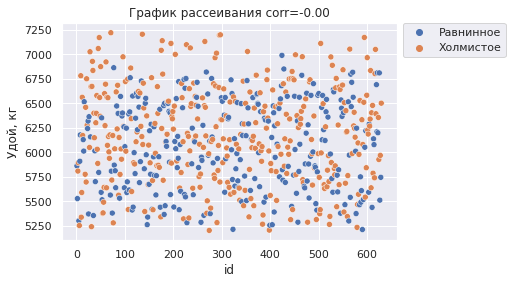

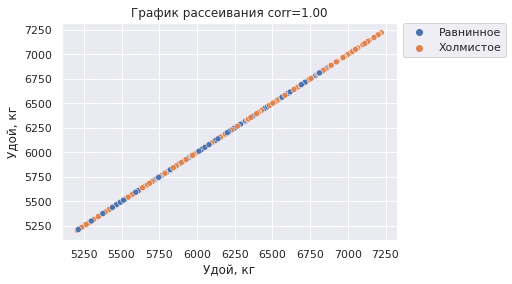

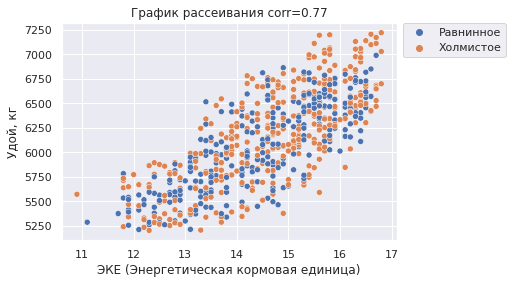

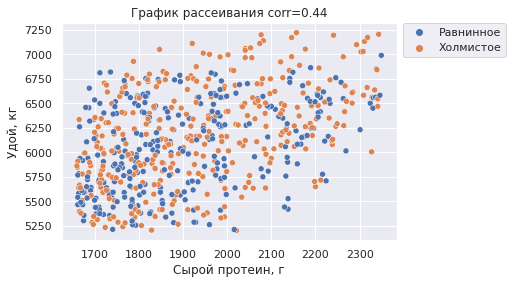

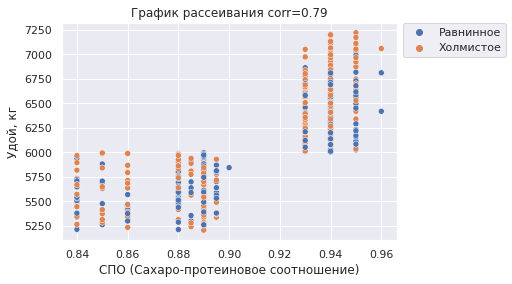

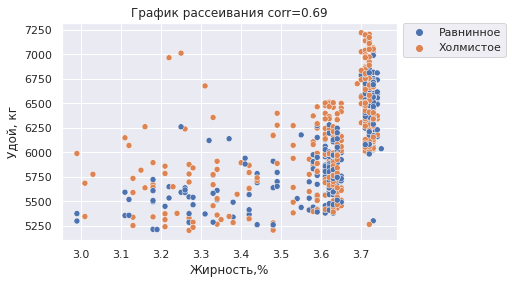

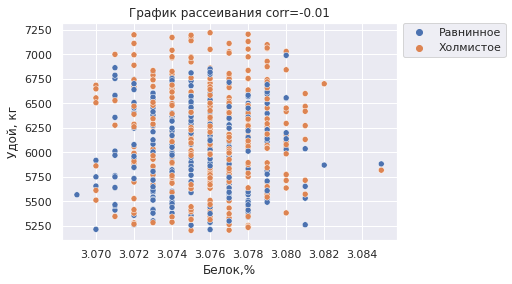

In [46]:
corr_farm_main('Тип пастбища')

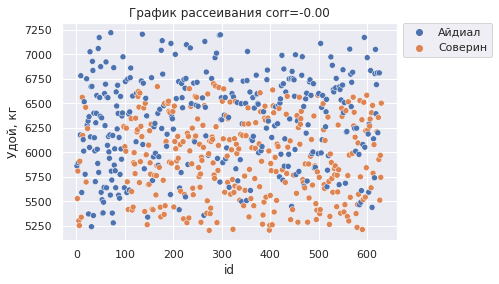

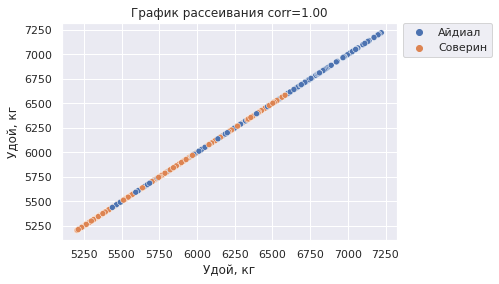

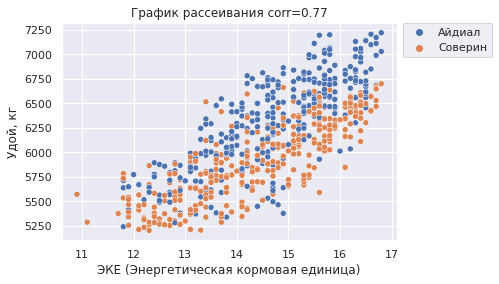

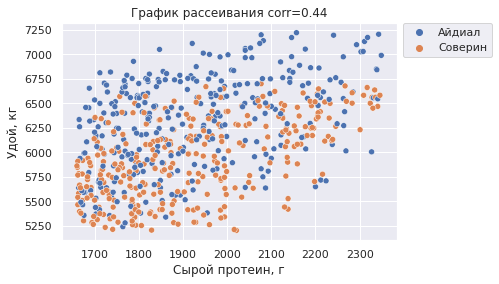

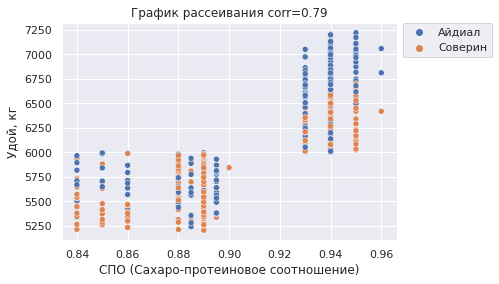

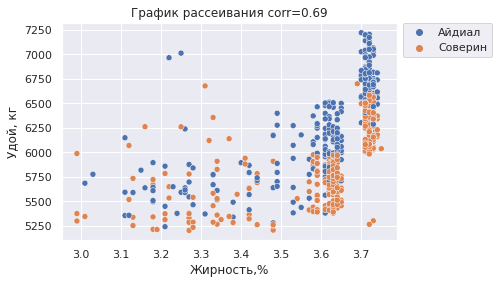

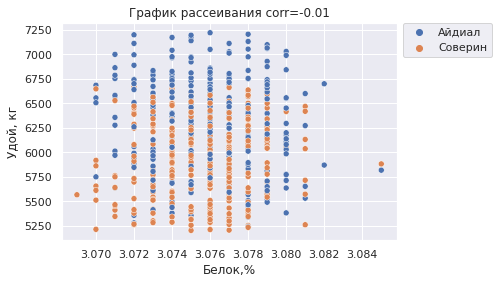

In [47]:
corr_farm_main('Порода папы быка')

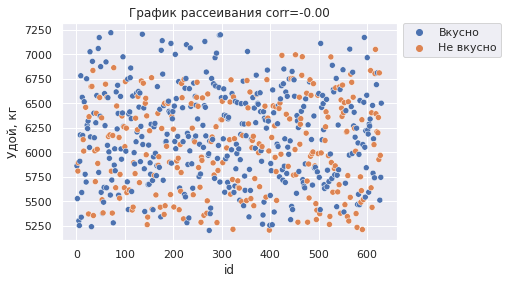

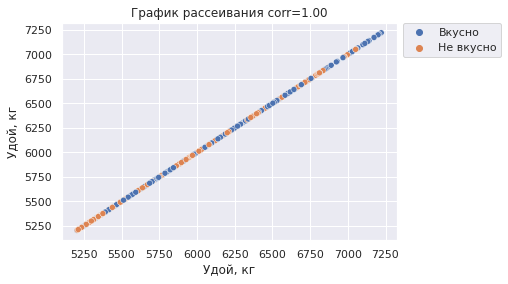

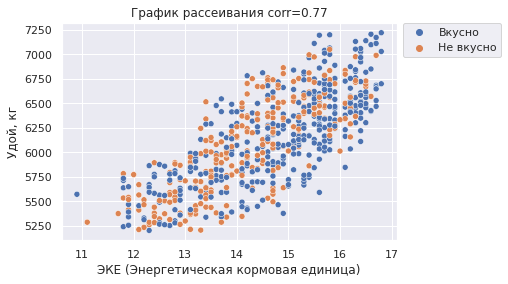

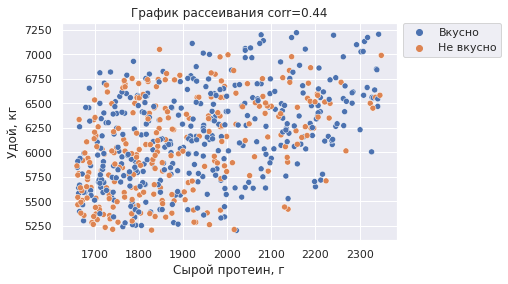

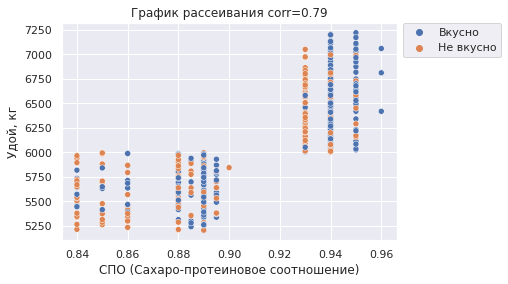

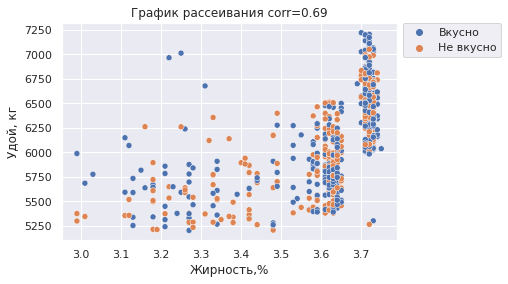

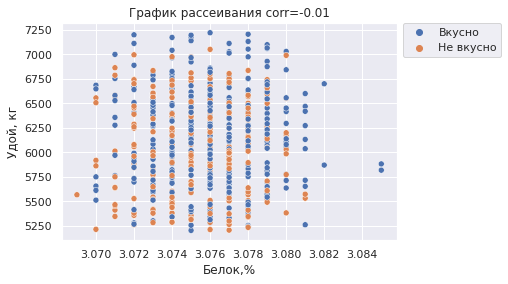

In [48]:
corr_farm_main('Вкус молока')

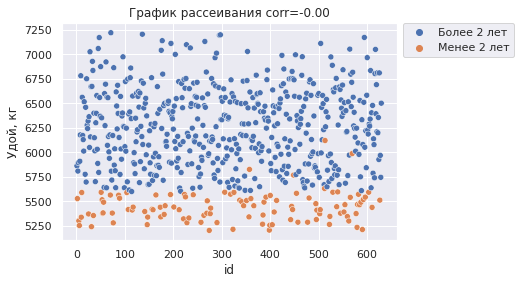

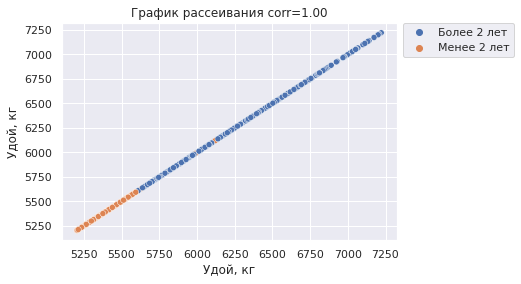

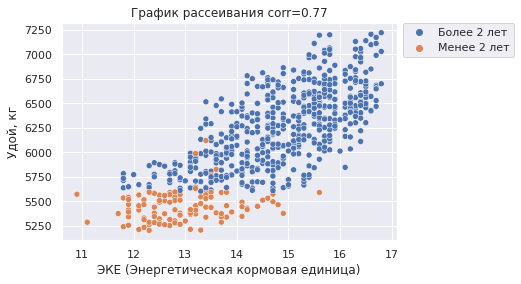

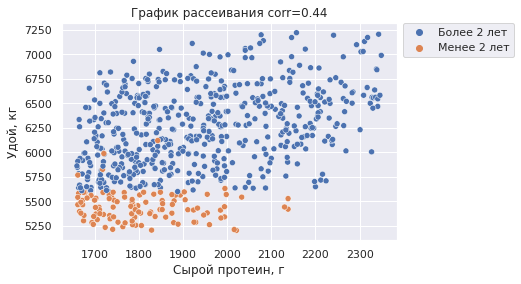

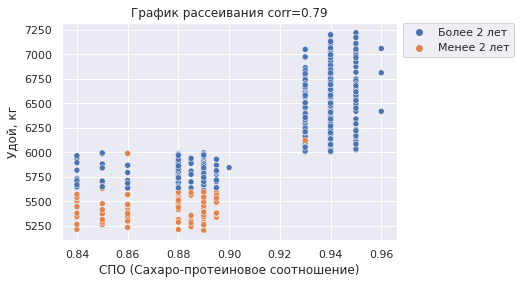

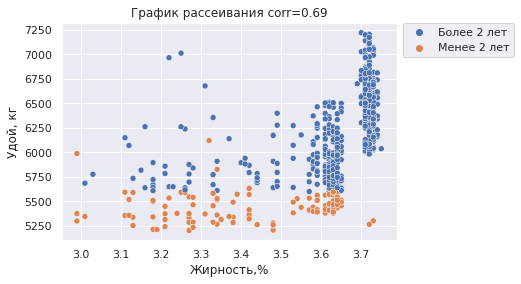

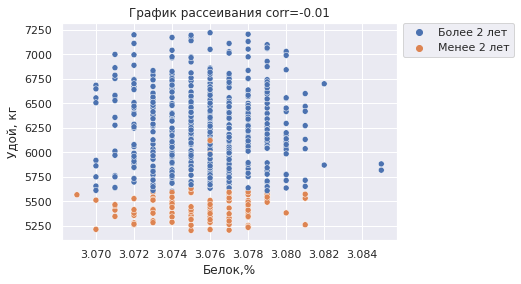

In [49]:
corr_farm_main('Возраст')

На графиках рассеивания видно зависимоть удоя от: ЭКЕ и СПО. ЭКЕ с удоем связно нелинейно (квадратично) и возведение ЭКЕ в степень улучшит наверняка линейную модель. 

### Выводы

- Наибольшая корелляция наблюдается между `Удой, кг` и `СПО (Сахаро-протеиновое соотношение)` (0.79), `Удой, кг` и `ЭКЕ (Энергетическая кормовая единица)` (0.77) и `СПО (Сахаро-протеиновое соотношение)` и `Жирность,%` (0.7). Следовательно, сильной линейной зависимости между значениями - нет, т.е. мультиколлинеарность отсутствует.
- На графиках рассеивания видно зависимоть удоя от: ЭКЕ и СПО. ЭКЕ с удоем связно нелинейно (квадратично) и возведение ЭКЕ в степень улучшит наверняка линейную модель. 

## Обучение модели линейной регрессии <a id='5'></a>

Выберем в качесте целевого признака удой. Признаки, которые нам не пригодятся: `Вкус молока`, `Жирность,%`, `Белок,%` - данные признак не влияет на количество молока, по которому можно спрогнозировать удой коров, т.к. это относиться к вкусовым предпочтениям. Для начала, запиши названия категориальных и колчисетвенных столбцов.

In [50]:
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст']
num_col_names =['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']

Теперь напишем функцию для рассчета первой модели. Найдем метрики R2, MAE, MSE, RMSE и доверительный интервал. Построим гистограмму и график рассеивания остатков.

In [51]:
def model_linear(df, cat_col, num_col):
    RANDOM_STATE = 42
    #разделям на тестовые и тренировочные
    X = df.drop(['Удой, кг'], axis=1)
    y = df['Удой, кг']
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        random_state=RANDOM_STATE)
    
    
    
    #закодируем категориальные признаки
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_ohe = encoder.fit_transform(X_train[cat_col])
    X_test_ohe = encoder.transform(X_test[cat_col])
    encoder_col_names = encoder.get_feature_names_out()
    
    
    # масштабируем количественные признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col])
    X_test_scaled = scaler.transform(X_test[num_col])
    
    # объеденим признаки
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    #обучение модели
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    y_pred = model_lr.predict(X_test)
    
    # метрики
    print(f"R2={r2_score(y_test, y_pred):.2f}")
    print(f"MAE={mean_absolute_error(y_test, y_pred):.0f}")
    print(f"MSE={mean_squared_error(y_test, y_pred):.2f}")
    print(f"RMSE={mean_squared_error(y_test, y_pred, squared = False):.2f}")
    
    #анализ остатков
    residuals = y_test - y_pred
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(y_pred ,residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()
    
    print(f"Доверительный интервал: {st.t.interval(confidence=0.95, df=len(y_pred)-1, loc=np.mean(y_pred), \
    scale=st.sem(y_pred))}")
    
    return  encoder, scaler, model_lr

R2=0.78
MAE=164
MSE=43887.02
RMSE=209.49


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


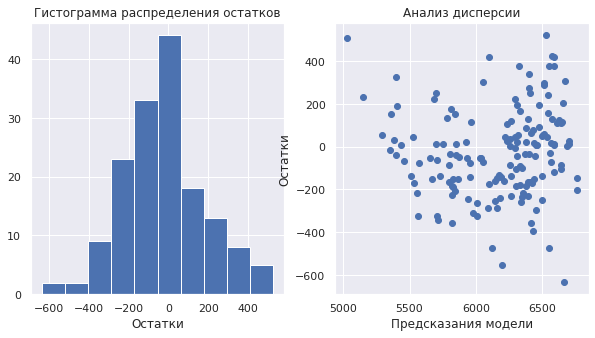

Доверительный интервал: (6105.532899815756, 6228.525774511475)


(OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
 StandardScaler(),
 LinearRegression())

In [52]:
model_linear(ferma_main, cat_col_names, num_col_names)

Модель в среднем ошибается на 164, точность модели составляет 78% при доверительном интервале (6106, 6229). Гистограмма показывает, в целом, нормальне распределение. Анализ дисперссии выявил разброс в значениях, т.е. не имеют постоянную дисперсию. Есть еще к чему стремиться. Изменим некоторые признаки: возьмем ранее преобразованный столбец `СПО 09`, а значения `ЭКЕ` возведем в квадрат и назовем: `ЭКЕ в квадрате`.

In [53]:
ferma_main['ЭКЕ в квадрате'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)']**2

Для 2 модели будут следующие признаки:
- категориальный: `Порода`, `Тип пастбища`, `Порода папы быка`, `Возраст`, `СПО 09`.
- количественные: `'Сырой протеин, г`, `ЭКЕ в квадрате`.

In [54]:
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО 09']
num_col_names =['ЭКЕ в квадрате', 'Сырой протеин, г']

А теперь посмотрим, что получиться.

R2=0.82
MAE=149
MSE=37030.91
RMSE=192.43


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


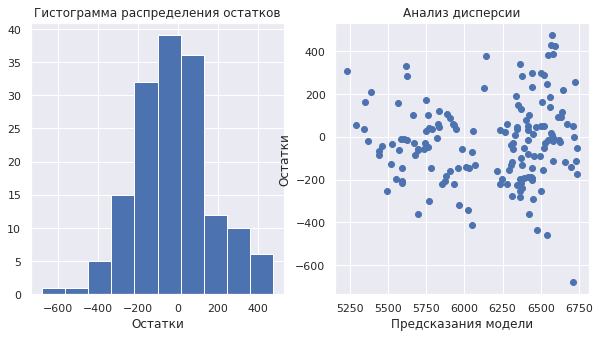

Доверительный интервал: (6102.607546734919, 6229.450151446973)


(OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
 StandardScaler(),
 LinearRegression())

In [55]:
model_linear(ferma_main, cat_col_names, num_col_names)

2 модель выглядит лучше 1. Модель стала ошибаться на 149, точность увеличилась на 82% при доверительном интервале (6103, 6230). На гистограмме видно, что остататки распределены тоже, в целом нормально. А на графике анализ дисперсси: разрос стал чуть ближе собираться к 0.  Но нет пределу совершенства! Добавим признак `Имя папы` в ferma_main из датафрейма `ferma_dad`.

In [56]:
ferma_main = ferma_main.merge(ferma_dad)

Еще раз обучим модель на новом признаке.

In [57]:
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО 09', 'Имя папы']
num_col_names =['ЭКЕ в квадрате', 'Сырой протеин, г']

R2=0.82
MAE=146
MSE=35673.89
RMSE=188.88


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


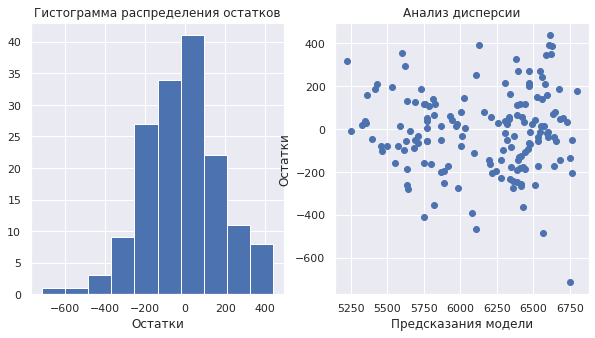

Доверительный интервал: (6091.835660789231, 6221.879485123438)


(OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
 StandardScaler(),
 LinearRegression())

In [58]:
model_linear(ferma_main, cat_col_names, num_col_names)

Имя отца немного улучшил метрику MAE (146), если сравнивать со второй моделью. Точность осталось прежней, как и гистограмма и диаграмма рассеяния.

Тем не менее, если рассматривать из 3 моделей, лучше выбрать последнюю, т.к. она показала наилучший результат. Для наглядности выпишу все результаты:

**Модель 1** 
- R2=0.78
- MAE=164
- MSE=43887.02
- RMSE=209.49
- Доверительный интервал: (6105.532899815756, 6228.525774511475)

**Модель 2**
- R2=0.82
- MAE=149
- MSE=37030.91
- RMSE=192.43
- Доверительный интервал: (6102.607546734919, 6229.450151446973)

**Модель 3**
- R2=0.82
- MAE=146
- MSE=35673.89
- RMSE=188.88
- Доверительный интервал: (6091.835660789231, 6221.879485123438)

Теперь спрогназируем удой коров для фермера. Вспоминаем условие, что корова должна давать не менее 6000 кг молока в год. Выбранная модель соотвествует данному условию, исходя из доверительного интервала (6092, 6222). К датасету cow_buy добавим признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение). Увеличим их на 5%.

In [59]:
cow_buy_6000 = cow_buy.copy()
cow_buy_6000

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Текущая жирность,%","Текущий уровень белок,%",Возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,Менее 2 лет
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.06,Более 2 лет
4,Рефлешн Соверинг,Равнинное,Айдиал,Буйный,3.64,3.07,Более 2 лет
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.05,Менее 2 лет
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,Более 2 лет
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.08,Менее 2 лет


R2=0.82
MAE=146
MSE=35673.89
RMSE=188.88


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


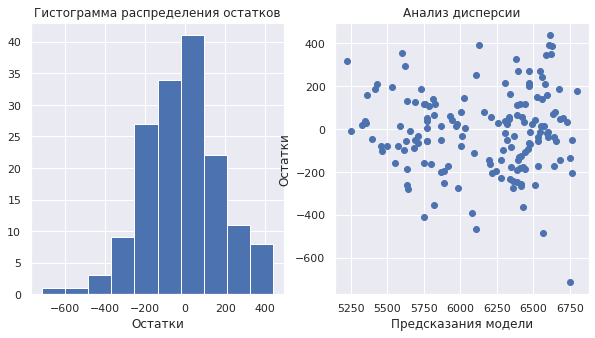

Доверительный интервал: (6091.835660789231, 6221.879485123438)


(OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
 StandardScaler(),
 LinearRegression())

In [60]:
model_linear(ferma_main, cat_col_names, num_col_names)

R2=0.82
MAE=146
MSE=35673.89
RMSE=188.88


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


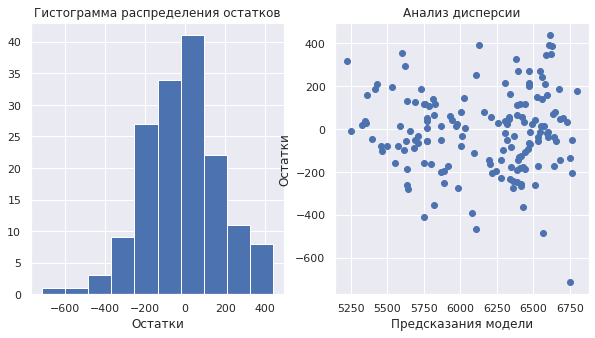

Доверительный интервал: (6091.835660789231, 6221.879485123438)


,Порода,Тип пастбища,Порода папы быка,Имя папы,"Текущая жирность,%","Текущий уровень белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),ЭКЕ в квадрате,СПО 09,"Удой, кг"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,609.92"
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,378.71"
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,284.00"
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.06,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,593.09"
4,Рефлешн Соверинг,Равнинное,Айдиал,Буйный,3.64,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,542.15"
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.05,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,425.38"
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,609.92"
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,571.26"
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,284.00"
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,400.54"


In [61]:
col=['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']

for _ in col:
    cow_buy_6000[_] = ferma_main[_].mean() * 1.05

cow_buy_6000['ЭКЕ в квадрате'] = cow_buy_6000['ЭКЕ (Энергетическая кормовая единица)'] ** 2
cow_buy_6000['СПО 09'] = cow_buy_6000['СПО (Сахаро-протеиновое соотношение)'].apply(spo)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО 09', 'Имя папы']
num_col_names =['ЭКЕ в квадрате', 'Сырой протеин, г']


_ = model_linear(ferma_main, cat_col_names, num_col_names)

encoder = _[0]

cow_buy_ohe = encoder.transform(cow_buy_6000[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)
   
scaler = _[1]
    
cow_buy_scaled = scaler.transform(cow_buy_6000[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

df_cow_buy = pd.concat([cow_buy_ohe,
                       cow_buy_scaled], axis=1)

model_lr = _[2]


cow_buy_pred = model_lr.predict(df_cow_buy)
df_cow_buy_6000 = cow_buy_6000
df_cow_buy_6000['Удой, кг'] = pd.DataFrame(cow_buy_pred)
df_cow_buy_6000.head(20)

Итак, мы получили прогноз удоя для данных cow_buy.

In [62]:
print('Количество коров, у которых удой 6000> в год', len(df_cow_buy_6000[df_cow_buy_6000['Удой, кг'] >= 6000]))

Количество коров, у которых удой 6000> в год 20


## Обучение модели логистической регрессии <a id='6'></a>

Для логистической модели выберем следующие признаки:
- категориальные: 'Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'СПО 09', 'Имя папы';
- количественные: 'ЭКЕ в квадрате', 'Сырой протеин, г', 'Белок,%','Жирность,%', 'СПО (Сахаро-протеиновое соотношение)', 'ЭКЕ (Энергетическая кормовая единица)'.

In [63]:
ferma_main['Вкус молока'] = ferma_main['Вкус молока'].replace({'Не вкусно': 0, 'Вкусно': 1})
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст', 'Имя папы']
num_col_names =['Сырой протеин, г', 'Белок,%','Жирность,%', 'СПО (Сахаро-протеиновое соотношение)', 
                'ЭКЕ (Энергетическая кормовая единица)']

Accuracy=0.61
Recall=0.85
Precision=0.61


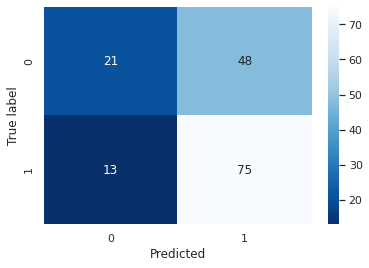

In [64]:
RANDOM_STATE = 42
#разделям на тестовые и тренировочные
X = ferma_main.drop(['Вкус молока'], axis=1)
y = ferma_main['Вкус молока']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=RANDOM_STATE)
#закодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()
       
# масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
    
# объеденим признаки
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
#обучение модели
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
    
# метрики
print(f"Accuracy={accuracy_score(y_test, y_pred):.2f}")
print(f"Recall={recall_score(y_test, y_pred):.2f}")
print(f"Precision={precision_score(y_test, y_pred):.2f}") 
    
#строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Помним, что главное для заказчика — вкусное молоко. Следовательно, исходя из полученных данных, видим что модель чаще совершает ошибки FP. Точность модели составляет 64%, есть к чему еще стремиться. Из полученной матрицы ошибок видим, модель чаще дает значение "вкусно" невкусному молоку. Следовательно будем работать с ошибками 1 рода и Precision. Далее сведем эту ошибку к 0: изменим порог принадлежности.

In [65]:
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

thresholds = [round(i,2) for i in np.linspace(0.7,0.9,num = 20,endpoint=False)]
#print(thresholds)

def count_valid_pred(y_valid,y_pred_):
    if y_valid < y_pred_:
        return 1
    return 0

values = []
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'] = data['y_proba'].apply( lambda y_proba: 1 if y_proba >= i  else  0)
    data['check'] = data.apply(lambda x : count_valid_pred(x.y_valid,x.y_pred_), 1)
    values.append(data['check'].sum())
    
df = pd.DataFrame(zip(columns, values),columns = ['Порог', 'Потери']) 
df

,Порог,Потери
0,y_pred_0.7,10
1,y_pred_0.71,10
2,y_pred_0.72,9
3,y_pred_0.73,9
4,y_pred_0.74,9
5,y_pred_0.75,6
6,y_pred_0.76,3
7,y_pred_0.77,2
8,y_pred_0.78,2
9,y_pred_0.79,2


Получили пороговое значение 0.81, которое минимизирует ошибку первого рода.

Accuracy=0.46
Recall=0.03
Precision=1.00


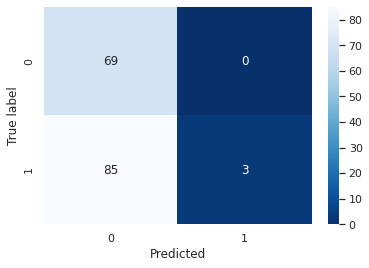

In [66]:
threshold= 0.81
y_pred_threshold = (y_proba > threshold).astype(int)

# метрики
print(f"Accuracy={accuracy_score(y_test, y_pred_threshold):.2f}")
print(f"Recall={recall_score(y_test, y_pred_threshold):.2f}")
print(f"Precision={precision_score(y_test, y_pred_threshold):.2f}") 
    
#строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Заказчик устнвновил, что молоко дожно быть вкусным: "не чуть не хуже". Следовательно, при таком условии будем считать минимальным порогом 0.82, другие значения будут выдвать ошибку 1 рода. Тем не менее, качество предсказания модели значительно уменьшилось до 46%. Конечно, для заказчика главное минимизировать риски, возможно для него сейчас главное репутация бренда, но в дальнейшем стоит подумать не только над репутацией бренда, но и над увелечением прибыли.

In [67]:
# забыла ранее изменитть названия столбцов в cow_buy
df_cow_buy_6000 = df_cow_buy_6000.rename(columns={'Текущая жирность,%' : 'Жирность,%', 
                                                  'Текущий уровень белок,%': 'Белок,%'})

In [68]:
cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы быка', 'Возраст',  'Имя папы']
num_col_names =['Сырой протеин, г', 'Белок,%','Жирность,%', 'СПО (Сахаро-протеиновое соотношение)', 'ЭКЕ (Энергетическая кормовая единица)']

In [69]:
cow_buy_taste_ohe = encoder.transform(df_cow_buy_6000[cat_col_names])
encoder_col_names = encoder.get_feature_names_out()

cow_buy_taste_ohe = pd.DataFrame(cow_buy_taste_ohe, columns=encoder_col_names)
   

cow_buy_taste_scaled = scaler.transform(df_cow_buy_6000[num_col_names])
cow_buy_taste_scaled = pd.DataFrame(cow_buy_taste_scaled, columns=num_col_names)

df_cow_buy_taste = pd.concat([cow_buy_taste_ohe, cow_buy_taste_scaled], axis=1)

cow_buy_taste_pred = clf.predict(df_cow_buy_taste)
y_proba = clf.predict_proba(df_cow_buy_taste)[:, 1]

df_cow_buy_6000_vkus = df_cow_buy_6000
df_cow_buy_6000_vkus['Вкус молока'] = pd.DataFrame(y_proba)
df_cow_buy_6000_vkus['Вкус молока'] = df_cow_buy_6000_vkus['Вкус молока'].apply(lambda x: 'Вкусно' if x > 0.8 else 'Не вкусно')
df_cow_buy_6000_vkus.head(20)

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),ЭКЕ в квадрате,СПО 09,"Удой, кг",Вкус молока
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,609.92",Не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,378.71",Не вкусно
2,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,284.00",Не вкусно
3,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.06,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,593.09",Не вкусно
4,Рефлешн Соверинг,Равнинное,Айдиал,Буйный,3.64,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,542.15",Не вкусно
5,Рефлешн Соверинг,Равнинное,Соверин,Геркулес,3.63,3.05,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,425.38",Не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,609.92",Не вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,571.26",Не вкусно
8,Рефлешн Соверинг,Равнинное,Соверин,Барин,3.59,3.07,Более 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,284.00",Не вкусно
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,400.54",Вкусно


Ура! Теперь последняя модель обучена предсказывать вкус молока.

In [70]:
print('Количество коров, у которых вкусное молоко', len(df_cow_buy_6000_vkus[df_cow_buy_6000_vkus['Вкус молока'] == 'Вкусно']))

Количество коров, у которых вкусное молоко 2


## Итоговые выводы <a id='7'></a>

In [71]:
df_cow_buy_6000_vkus = df_cow_buy_6000_vkus[(df_cow_buy_6000_vkus['Удой, кг'] >= 6000) & (df_cow_buy_6000_vkus['Вкус молока'] == 'Вкусно')]
df_cow_buy_6000_vkus

,Порода,Тип пастбища,Порода папы быка,Имя папы,"Жирность,%","Белок,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),ЭКЕ в квадрате,СПО 09,"Удой, кг",Вкус молока
9,Рефлешн Соверинг,Холмистое,Айдиал,Буйный,3.40,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,400.54",Вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.08,Менее 2 лет,15.28,"2,019.95",0.96,233.36,больше 0.9,"6,127.47",Вкусно


In [72]:
df_cow_buy_6000_vkus['Порода'].count()

2

По результатам прогнозирования ключевых метрик, фермеру рекомендовано приобрести 2 коровы из первоначальных данных с минимальным риском для своего хозяйства.Это обусловлено тем, что:
1. Риск потерь минимален благодаря успешной модели предсказания удоя, которая имеет высокий показатель прогноза (82%) и небольшую среднюю ошибку (146 кг). Для улучшения предсказания удоя нужно добавить новые признаки, например условия содержания коров, частота дояения коров и т.д.
2. Исходя из ТЗ, выборка коров осуществлялась только среди тех, у которых молоко является вкусным. Было исключены ошибки 1 рода, но сильно упала точность модели до 46%. Для более точного предсказания лучше чтобы ошибка допускалась, тогда модель будет более точнее давать прогноз.

В проекте использовались 2 модели:
1. Линейная с метриками  MAE, MSE, MRSE и коэффицент детерминации R2. Лучше всего получислось интерпритовровать модель с первым и последним показателем. C помощью MAE мы сравниваем качество модели по мере настройки обучения, а R2 нужен для сравнения двух регриссионных моделей. При корелляционном анализе выявили, что удой не имеет линейную связь с такими признаками, как :ЭКЕ и СПО. Признак ЭКЕ была возведена в квадрат, а СПО - сделали категориальным признаком. После преобразовавания качество модели значительно улучшилось. Для последней модели добавили признак имя отца, не сказать что точность модели сильно увеличилась (а точнее никак не поменялась), но ошибок стало меньше. Было решено взять последнюю модель для прогнозирования удоя для cow_buy.
2. Логистическая регрессия с метриками Accuracy, Precision, Recall. Взяли метрики Accuracy, Precision, исходя из ТЗ заказчика. Accuracy покзывает доля правильных ответов, а Precision долю объектов, названных классификатором положительными и при этом действительно являющимися положительными. В ходе изучения модели и постановки первичной задачи, было решено изменить порого классификации, что привело исключение ошибок FP, но, как было выше сказанно, уменьшилосб точность модели.